Import data from previous notebook and librairies

#### WARNING DONT RUN BEFORE THE PREVIOUS NOTEBOOK WE NEED prediction.csv

In [30]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import uniform
from tqdm import tqdm
import time
import os
import sys

file_path = 'predictions.csv'
if not os.path.exists(file_path):
    sys.exit(f"The file {file_path} does not exist. Please make sure the file is available before running the script.")

pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv('predictions.csv')

data.head()


SystemExit: The file predictions.csv does not exist. Please make sure the file is available before running the script.

Creation of class Data, where it setup all model, and have a public method run to benchmark differents model with the datasett using Kfold to try different setup of tain/test data.
All model use CV to setup best hyperparameters.
Here we do an export to make a test in next notebook.

In [22]:
class Data:
    def __init__(self, data, y_n):
        self.epoch = 5
        self.layout = {
            'linear R2': [],
            'ridge R2': [],
            'lasso R2': [],
            'elastic R2': [],
            'ridge alpha': [],
            'lasso alpha': [],
            'elastic alpha': [],
            'elastic l1_ratio': [],
            'random forest R2': [],
            'xgboost R2': [],
            'random forest params': [],
            'xgboost params': [],
            'linear time': [],
            'ridge time': [],
            'lasso time': [],
            'elastic time': [],
            'random forest time': [],
            'xgboost time': []
        }
        self.iter = 0
        self.origin = data.copy()
        self.y_n = y_n
        self.data = data
        self.preprocess()
        self.y = self.data.iloc[:, y_n]
        self.data = self.data.iloc[:, 2:]
        print(f"Prediction {self.y.name}")
        
    def preprocess(self):
        scaler = StandardScaler()
        self.data = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)

    def run(self):
        kf = KFold(n_splits=self.epoch, shuffle=True, random_state=42)
        models = [
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            RandomForestRegressor(),
            xgb.XGBRegressor()
        ]
        total_steps_per_epoch = 6
        with tqdm(total=kf.get_n_splits() * total_steps_per_epoch, desc="Epoch Progress") as pbar:
            for train_index, test_index in kf.split(self.data):
                self.X_train, self.X_test = self.data.iloc[train_index], self.data.iloc[test_index]
                self.y_train, self.y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                self.linear_regression(models[0])
                pbar.update(1)
                self.ridge_regression(models[1])
                pbar.update(1)
                self.lasso_regression(models[2])
                pbar.update(1)
                self.elastic_net(models[3])
                pbar.update(1)
                self.random_forest_regression(models[4])
                pbar.update(1)
                self.xgboost_regression(models[5])
                pbar.update(1)            
        return self.layout

    def linear_regression(self, model):
        start_time = time.time()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        end_time = time.time()
        self.layout['linear R2'].append(r2_score(self.y_test, pred))
        self.layout['linear time'].append(end_time - start_time)
        return model

    def ridge_regression(self, model):
        start_time = time.time()
        param_distributions_ridge = {'alpha': uniform(0.01, 1000)}
        random_search_ridge = RandomizedSearchCV(model, param_distributions_ridge, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_ridge.fit(self.X_train, self.y_train)
        best_ridge = random_search_ridge.best_estimator_
        pred = best_ridge.predict(self.X_test)
        end_time = time.time()
        self.layout['ridge R2'].append(r2_score(self.y_test, pred))
        self.layout['ridge alpha'].append(random_search_ridge.best_params_['alpha'])
        self.layout['ridge time'].append(end_time - start_time)
        return best_ridge

    def lasso_regression(self, model):
        start_time = time.time()
        param_distributions_lasso = {'alpha': uniform(0.01, 1000)}
        random_search_lasso = RandomizedSearchCV(model, param_distributions_lasso, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_lasso.fit(self.X_train, self.y_train)
        best_lasso = random_search_lasso.best_estimator_
        pred = best_lasso.predict(self.X_test)
        end_time = time.time()
        self.layout['lasso R2'].append(r2_score(self.y_test, pred))
        self.layout['lasso alpha'].append(random_search_lasso.best_params_['alpha'])
        self.layout['lasso time'].append(end_time - start_time)
        return best_lasso

    def elastic_net(self, model):
        start_time = time.time()
        param_distributions_elastic_net = {
            'alpha': uniform(0.01, 1000),
            'l1_ratio': uniform(0, 1)
        }
        random_search_elastic_net = RandomizedSearchCV(model, param_distributions_elastic_net, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_elastic_net.fit(self.X_train, self.y_train)
        best_elastic_net = random_search_elastic_net.best_estimator_
        pred = best_elastic_net.predict(self.X_test)
        end_time = time.time()
        self.layout['elastic R2'].append(r2_score(self.y_test, pred))
        self.layout['elastic alpha'].append(random_search_elastic_net.best_params_['alpha'])
        self.layout['elastic l1_ratio'].append(random_search_elastic_net.best_params_['l1_ratio'])
        self.layout['elastic time'].append(end_time - start_time)
        return best_elastic_net

    def random_forest_regression(self, model):
        start_time = time.time()
        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        random_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
        random_search_rf.fit(self.X_train, self.y_train)
        best_rf = random_search_rf.best_estimator_
        pred = best_rf.predict(self.X_test)
        end_time = time.time()
        self.layout['random forest R2'].append(r2_score(self.y_test, pred))
        self.layout['random forest params'].append(random_search_rf.best_params_)
        self.layout['random forest time'].append(end_time - start_time)
        return best_rf

    def xgboost_regression(self, model):
        start_time = time.time()
        param_distributions_xgb = {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 6, 10],
            'learning_rate': uniform(0.01, 0.3),
            'alpha': uniform(0, 1)
        }
        random_search_xgb = RandomizedSearchCV(model, param_distributions_xgb, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_xgb.fit(self.X_train, self.y_train)
        best_xgb = random_search_xgb.best_estimator_
        pred = best_xgb.predict(self.X_test)
        end_time = time.time()
        self.layout['xgboost R2'].append(r2_score(self.y_test, pred))
        self.layout['xgboost params'].append(random_search_xgb.best_params_)
        self.layout['xgboost time'].append(end_time - start_time)
        return best_xgb

Transorme the result from the class method run to dataframe to use it later and run the tests
here the prediction of energy use from previous notebook to see with this parameter upgrade our result

In [23]:
df = Data(data, 0)

res = pd.DataFrame(df.run())
res.head()

Prediction TotalGHGEmissions


Epoch Progress: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


,linear R2,ridge R2,lasso R2,elastic R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest R2,xgboost R2,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-5085934764354459283910295552.000000,0.681670,-0.000769,-0.000769,382.515512,245.389981,828.399326,0.851191,0.786230,0.655069,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.8712387272766622, 'learning_rate':...",0.012018,0.331635,0.313710,0.294616,6.151374,3.341841
1,-1503544024149428625188323328.000000,0.683935,-0.001216,-0.001216,220.679767,437.902370,859.096030,0.586796,0.939842,0.740255,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.8674261709550215, 'learning_rate':...",0.013017,0.321621,0.287992,0.261564,6.026591,3.057228
2,-123337378534563932236939264.000000,0.774263,-0.000237,-0.000237,269.304019,824.961933,951.116514,0.071861,0.715429,0.847236,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.9849544839962256, 'learning_rate':...",0.014029,0.311940,0.287025,0.268110,6.319313,2.367086
3,-9295437656926259267103621120.000000,0.811340,-0.000066,-0.000066,246.538683,261.962530,433.275765,0.351745,0.831881,0.901579,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.8180674959464016, 'learning_rate':...",0.014030,0.318539,0.277590,0.284103,5.980990,2.333526
4,-10415830157013617406377984.000000,0.734396,-0.000269,-0.000269,22.812864,392.352362,711.829030,0.412274,0.669313,0.701182,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.49379916320954953, 'learning_rate'...",0.012523,0.311224,0.278186,0.265175,6.093183,3.363856


Calculation of means to compare all model and visualisation - R2

              index         0
0         linear R2 -1.000000
1          ridge R2  0.737121
2          lasso R2 -0.000511
3        elastic R2 -0.000511
4  random forest R2  0.788539
5        xgboost R2  0.769064


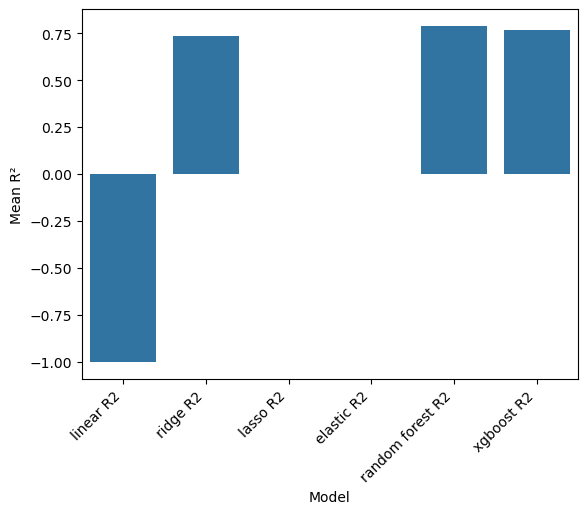

In [24]:
list_r2  = ['linear R2', 'ridge R2', 'lasso R2', 'elastic R2','random forest R2','xgboost R2']
res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

scores_r2 = res[list_r2].mean().reset_index()
print(scores_r2)
scores_r2.columns = ['Model', 'Mean R²']
sns.barplot(x='Model', y='Mean R²', data=scores_r2)
plt.xticks(rotation=45, ha='right')
plt.show()

All model intresting model from last tests are bit better exept random forsest

                index        0
0         linear time 0.013124
1          ridge time 0.318992
2          lasso time 0.288901
3        elastic time 0.274714
4  random forest time 6.114290
5        xgboost time 2.892707


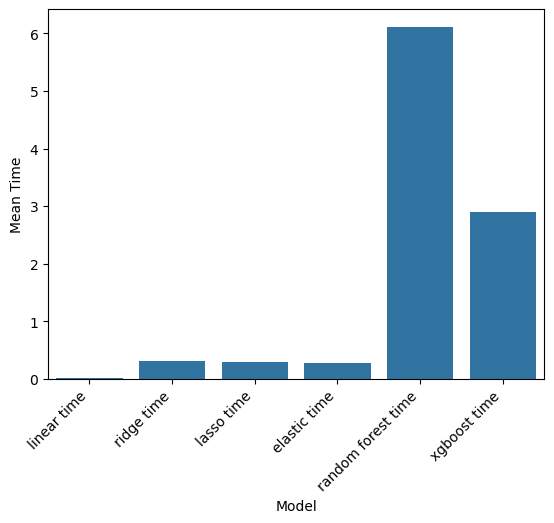

In [25]:
time = res[['linear time',	'ridge time',	'lasso time',	'elastic time',	'random forest time',	'xgboost time']].mean().reset_index()
print(time)
time.columns = ['Model', 'Mean Time']
sns.barplot(x='Model', y='Mean Time', data=time)
plt.xticks(rotation=45, ha='right')
plt.show()

The time is similar to last tests, So if we choose ridge or random forest it can be a good idee to use prediction from energy usage, but if we keep random forest it's better to not use this method